In [ ]:
# EDA

I'm not going to use Philip's ACO.io library, which was probably invaluable for getting the MP3s together, but obscures a bit much of the data for my purposes, where I know roughly w


In [1]:
from datetime import datetime

import numpy as np
from numpy.fft import fft, ifft
from matplotlib import pyplot as plt
from scipy import signal
import pydub

import mp3_util
from const import SAMPLES_PER_SEC, SAMPLE_LENGTH

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
DATA_DIR = 'data/

SyntaxError: EOL while scanning string literal (<ipython-input-3-ad8c2fae8642>, line 1)

In [3]:
!ls data/every_other_hour/2015/01/01

2015-01-01--00.00.mp3  2015-01-01--08.00.mp3  2015-01-01--16.00.mp3
2015-01-01--02.00.mp3  2015-01-01--10.00.mp3  2015-01-01--18.00.mp3
2015-01-01--04.00.mp3  2015-01-01--12.00.mp3  2015-01-01--20.00.mp3
2015-01-01--06.00.mp3  2015-01-01--14.00.mp3  2015-01-01--22.00.mp3


In [4]:
mp3_arr = mp3_util.load_mp3_arr_from_date(datetime(2015,4,1))

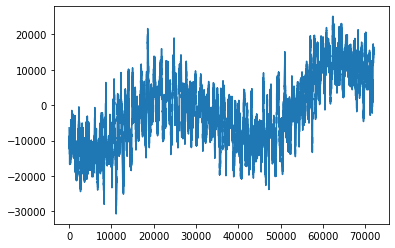

In [91]:
plt.plot(mp3_arr[::100])
plt.show()

In [10]:
import sys

In [12]:
for obj in locals():
   print(obj, sys.getsizeof(obj))


__name__ 57
__doc__ 56
__package__ 60
__loader__ 59
__spec__ 57
__builtin__ 60
__builtins__ 61
_ih 52
_oh 52
_dh 52
In 51
Out 52
get_ipython 60
exit 53
quit 53
_ 50
__ 51
___ 52
getenv 55
options 56
set_printoptions 65
_i 51
_ii 52
_iii 53
_i1 52
datetime 57
np 51
fft 52
ifft 53
plt 52
signal 55
pydub 54
mp3_util 57
SAMPLES_PER_SEC 64
SAMPLE_LENGTH 62
_i2 52
_i3 52
_i4 52
mp3_arr 56
_i5 52
_i6 52
_i7 52
_i8 52
_i9 52
obj 52
_i10 53
sys 52
_i11 53
_i12 53


In [10]:
f,t, Zxx = signal.stft(mp3_arr, SAMPLES_PER_SEC, nperseg=4096)

In [11]:
def combine_buckets(Z):
    aZ = np.abs(Z)
    num_bucket = np.log2(aZ.shape[0]).astype(int)
    bZ = np.zeros((num_bucket+1, aZ.shape[1]))
    for i in range(num_bucket):
        i0 = (2**i) -1
        i1 = (2**(i+1)) - 1
        bZ[i] = np.sum(aZ[i0:i1])
    return bZ

In [12]:
Bz = combine_buckets(Zxx)

In [13]:
Bz.shape

(12, 3517)

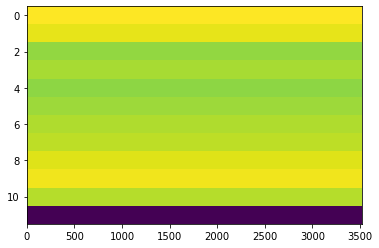

In [14]:
fig, ax = plt.subplots()
plt.imshow(np.log10(np.abs(Bz)+1), aspect='auto')
plt.show()

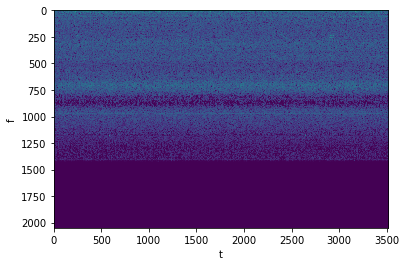

In [15]:
plt.imshow(np.log10(np.abs(Zxx)+1), aspect='auto')
plt.xlabel('t')
plt.ylabel('f')
plt.show()



In [ ]:
Really needs a log-y scale. Could try to filter the result via convolution.

Really also need to use a high-pass and low-pass filters to reduce the noise.

Could then try building up average sound profile, subtracting off. 

In [ ]:
import pydub


## Power Spectra and De-Noising


Let's try building a Wiener filter.  It basically models a signal as
$ x(t) = s(t) + \eta(t)$, where $\xi(t)$ is some noise process, with spectrum based on it's auto-correlation function.

(Talking to John Burt, this is might be a bad idea, nonetheless, let's see what happens.)

The full Wiener filter is:
\begin{equation}
G(f) = \frac{H^{*}(f) S(f)}{|H(f)|^2S(f) + N(f)}
\end{equation}
where $H(f)$ is the spectrum of the recorder, $S(f)$ is the transfer function of the signal, and $N(f)$ is the spectrum of the noise.

Note: with these fft convetions a delta goes to $N_{sample}$

For my purposes, I don't have any of these.  For a first step, We can estimate this using $H$ as a 1, as a perfect input.
We can treat $S$ as any signal, and do $N$ as all the average spectra.

At this point, it's not too dis-similar to subtracting off the mean?

This is the average spectrum across all every-other-hour samples.

Average scale is on the order of 20000.  And 

In [14]:
filt = mp3_util.load_filter_from_pickle('total_spec')

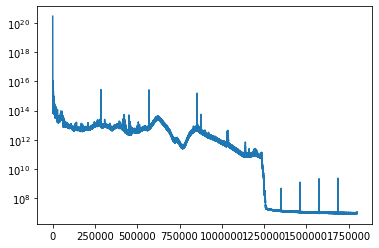

In [93]:
plt.semilogy(filt[:int(len(filt)/2):2])
plt.show()

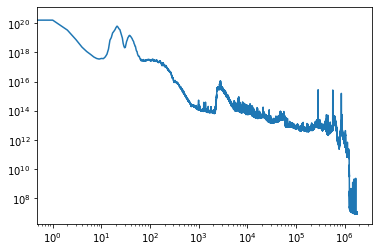

In [95]:
plt.loglog(filt[:int(len(filt)/2):2])
plt.show()


So comments:
That's a pretty big scale.  Average amplitude is 20000 units.  I think the FFT convention also multiples by N.  Given there's around 24k samples for 300 sec, there are 75000000  or $10^7$ samples.  Square that, and multiply by amplitude and you get around 10^20.

In [96]:
Ntby2 = int(len(mp3_arr)/2)

In [104]:
mp3_filt, fw, filt_fw = mp3_util.remove_noise_wiener(mp3_arr, filt)

4.4112977089494323e+18 2.6912722749503334e+18


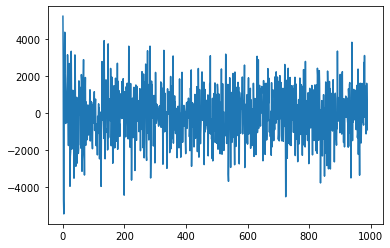

In [105]:
plt.plot(mp3_filt[1000:100000:100])
plt.show()

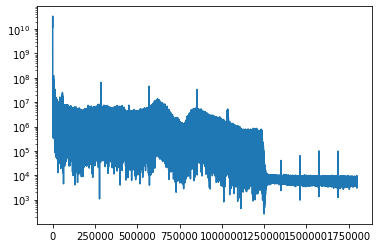

In [106]:
plt.semilogy(np.abs(fw[:Ntby2:2])); plt.show()

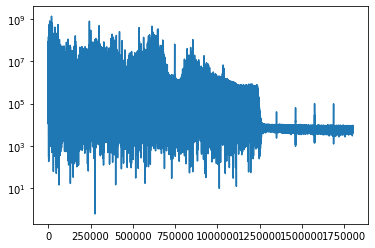

In [107]:
plt.semilogy(np.abs(filt_fw[:Ntby2:2])); plt.show()


In [35]:
from sys import getsizeof

In [82]:
size = []
for var, obj in locals().items():
    if isinstance(obj, np.ndarray):
        size.append((var, obj.nbytes))
    else:
        size.append((var, getsizeof(obj)))

In [83]:
sorted(size, key=lambda x: x[1], reverse=True)

[('filt', 57600000),
 ('fw', 28800000),
 ('filt_fw', 28800000),
 ('mp3_arr', 15300070),
 ('mp3_filt', 14400000),
 ('_68', 1168),
 ('_69', 1168),
 ('_70', 1168),
 ('_71', 1168),
 ('size', 1072),
 ('_ih', 768),
 ('In', 768),
 ('_oh', 648),
 ('Out', 648),
 ('datetime', 400),
 ('_i1', 271),
 ('_i24', 237),
 ('_i29', 237),
 ('_i31', 231),
 ('_i73', 222),
 ('_i78', 222),
 ('_i64', 220),
 ('_i82', 220),
 ('_i62', 219),
 ('_i63', 219),
 ('_i43', 193),
 ('_i44', 193),
 ('_i45', 193),
 ('_i46', 193),
 ('_i56', 193),
 ('_i61', 193),
 ('_i34', 190),
 ('_i36', 190),
 ('_i37', 180),
 ('_i42', 180),
 ('_i38', 177),
 ('getenv', 136),
 ('set_printoptions', 136),
 ('fft', 136),
 ('ifft', 136),
 ('get_var_size', 136),
 ('_74', 136),
 ('___', 120),
 ('_79', 120),
 ('_i17', 116),
 ('_i23', 116),
 ('_i28', 116),
 ('_i55', 116),
 ('_i57', 116),
 ('_i60', 116),
 ('_i72', 116),
 ('__doc__', 113),
 ('_i54', 112),
 ('_i59', 112),
 ('_i4', 110),
 ('_i52', 110),
 ('_i53', 110),
 ('_i21', 105),
 ('_i12', 104),
 ('_

In [81]:
size[0][1]/1024

56250.0